# Multi-task learning from cell line perturbation

* Authors: Eshika Saxena, Doris Fu
* Objective: Implement and train multi-task classifier model to predict positive/negative cell viability score from encoded cell line RNA-seq profile. Fine-tune the pre-trained multi-task classifier model on patient data for patient long/short term pfs classification.

## Load libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import os 
import shutil

import copy

import tensorflow as tf
import tensorflow.keras as K

from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression

import CCLE_utils
import MMRF_utils

In [2]:
tf.random.set_seed(221)

## Load encoded cell line data

In [3]:
with pd.HDFStore('normalized_embeddings.h5') as store:
    print(store.keys())

['/ccle_test_ccleae', '/ccle_test_combinedae', '/ccle_test_mmrfae', '/ccle_train_ccleae', '/ccle_train_combinedae', '/ccle_train_mmrfae', '/ccle_valid_ccleae', '/ccle_valid_combinedae', '/ccle_valid_mmrfae', '/mmrf_test_ccleae', '/mmrf_test_combinedae', '/mmrf_test_mmrfae', '/mmrf_train_ccleae', '/mmrf_train_combinedae', '/mmrf_train_mmrfae', '/mmrf_valid_ccleae', '/mmrf_valid_combinedae', '/mmrf_valid_mmrfae']


In [4]:
X_train = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_train_mmrfae', index_col=1)
X_train = X_train.set_index(X_train.iloc[:, 0])
X_train = X_train.iloc[: , 1:]

X_val = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_valid_mmrfae', index_col=1)
X_val = X_val.set_index(X_val.iloc[:, 0])
X_val = X_val.iloc[: , 1:]

X_test = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_test_mmrfae', index_col=1)
X_test = X_test.set_index(X_test.iloc[:, 0])
X_test = X_test.iloc[: , 1:]

In [5]:
crispr_rnaseq_merged = pd.read_csv('rnaseq_crispr_merged.csv')
crispr_rnaseq_merged = crispr_rnaseq_merged.set_index(['DepMap_ID'])
response_cols = [col for col in crispr_rnaseq_merged.columns if '_y' in col]
crispr = crispr_rnaseq_merged[response_cols]

In [6]:
train_index = list(set(X_train.index).intersection(crispr.index))
val_index = list(set(X_val.index).intersection(crispr.index))
test_index = list(set(X_test.index).intersection(crispr.index))

In [7]:
X_train = X_train.loc[train_index]
Y_train = crispr.loc[train_index]

X_val = X_val.loc[val_index]
Y_val = crispr.loc[val_index]

X_test = X_test.loc[test_index]
Y_test = crispr.loc[test_index]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(559, 128) (559, 13)
(165, 128) (165, 13)


In [8]:
#binary outcome used for classifier; positive = 1, negative = 0
bY_train = (Y_train >0).astype(int)
bY_val = (Y_val >0).astype(int)
bY_test = (Y_test >0).astype(int)

In [9]:
# onehot encode binary outcomes
bY_train_oneHot = K.utils.to_categorical(bY_train, 2)
bY_val_oneHot = K.utils.to_categorical(bY_val, 2)
bY_test_oneHot = K.utils.to_categorical(bY_test, 2)

print(bY_train_oneHot.shape, bY_val_oneHot.shape, bY_test_oneHot.shape)

(559, 13, 2) (77, 13, 2) (165, 13, 2)


## Load MMRF data

In [10]:
X_train_pt = pd.read_hdf("normalized_embeddings.h5", key = 'mmrf_train_mmrfae', index_col=1)
X_train_pt = X_train_pt.set_index(X_train_pt.iloc[:, 0])
X_train_pt = X_train_pt.iloc[: , 1:]

X_val_pt = pd.read_hdf("normalized_embeddings.h5", key = 'mmrf_valid_mmrfae', index_col=1)
X_val_pt = X_val_pt.set_index(X_val_pt.iloc[:, 0])
X_val_pt = X_val_pt.iloc[: , 1:]

X_test_pt = pd.read_hdf("normalized_embeddings.h5", key = 'mmrf_test_mmrfae', index_col=1)
X_test_pt = X_test_pt.set_index(X_test_pt.iloc[:, 0])
X_test_pt = X_test_pt.iloc[: , 1:]

In [11]:
train_patient_all = pd.DataFrame()
valid_patient_all = pd.DataFrame()
test_patient_all = pd.DataFrame()

for ind in [1]:
    data_filename = './data/cleaned_mm%d_2mos_pfs_ind.pkl'%(ind)
    train, test, valid = MMRF_utils.get_train_test_valid(data_filename, ind, show_features=True)

    print('\nPreprocess patient data in MMRF')
    # include the first n clinical visit data for each patient (default 0)
    train_df = MMRF_utils.preprocess_patient_data(train, num_clin_visits=3)  
    print(train_df.shape)

    valid_df = MMRF_utils.preprocess_patient_data(valid, num_clin_visits=3)  
    print(valid_df.shape)

    test_df = MMRF_utils.preprocess_patient_data(test, num_clin_visits=3)  
    print(test_df.shape)

    print('\nPreprocess patient genomic data in MMRF...')
    genomic_fn = './data/MMRF_CoMMpass_IA15a_E74GTF_Salmon_Gene_TPM.txt'
    genomic_df = MMRF_utils.preprocess_genomic_data(genomic_fn, nPCA=0)
    print(genomic_df.shape)

    print('\nMerging patient data with genomic data...')
    train_patient_all = train_patient_all.append(train_df.merge(genomic_df, left_on='pids', right_on='pids'))

    valid_patient_all = valid_patient_all.append(valid_df.merge(genomic_df, left_on='pids', right_on='pids'))

    test_patient_all = test_patient_all.append(test_df.merge(genomic_df, left_on='pids', right_on='pids'))

loading from: ./data/cleaned_mm1_2mos_pfs_ind.pkl
pids
(494,)
x
(494, 33, 16)
m
(494, 33, 16)
feature_names_x
(16,)
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']
ys_seq
(494, 1)
ce
(494, 1)
feature_names_y
(1,)
['progression free survival (all)']
b
(494, 16)
feature_names
(16,)
Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')
a
(494, 33, 9)
m_a
(494, 33, 6)
feature_names_a
(9,)
['local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len' 'line1' 'line2' 'line3plus']

Preprocess patient data in MMRF
Keep first 3 clinical visits.
(461, 93)
Keep first 3 clinical visits.
(161, 93)
Keep first 3 clinical visits.
(214, 93)

Preprocess patient genomic data 

In [12]:
train_pfs = train_patient_all[['pids','pfs']]
train_pfs = train_pfs.set_index('pids')

val_pfs = valid_patient_all[['pids','pfs']]
val_pfs = val_pfs.set_index('pids')

test_pfs = test_patient_all[['pids','pfs']]
test_pfs = test_pfs.set_index('pids')

In [13]:
train_index_pt = list(set(X_train_pt.index).intersection(train_pfs.index))
val_index_pt = list(set(X_val_pt.index).intersection(val_pfs.index))
test_index_pt = list(set(X_test_pt.index).intersection(test_pfs.index))

In [14]:
X_train_pt = X_train_pt.loc[train_index_pt]
Y_train_pfs = train_pfs.loc[train_index_pt]

X_val_pt = X_val_pt.loc[val_index_pt]
Y_val_pfs = val_pfs.loc[val_index_pt]

X_test_pt = X_test_pt.loc[test_index_pt]
Y_test_pfs = test_pfs.loc[test_index_pt]

In [15]:
print(X_train_pt.shape, Y_train_pfs.shape)
print(X_test_pt.shape, Y_test_pfs.shape)

(313, 128) (313, 1)
(142, 128) (142, 1)


In [16]:
bY_train_pfs = (Y_train_pfs >12).astype(int)
bY_val_pfs = (Y_val_pfs >12).astype(int)
bY_test_pfs = (Y_test_pfs >12).astype(int)

In [17]:
# onehot encode binary outcomes
bY_train_pfs_oneHot = K.utils.to_categorical(bY_train_pfs, 2)
bY_val_pfs_oneHot = K.utils.to_categorical(bY_val_pfs, 2)
bY_test_pfs_oneHot = K.utils.to_categorical(bY_test_pfs, 2)

print(bY_train_pfs_oneHot.shape, bY_val_pfs_oneHot.shape, bY_test_pfs_oneHot.shape)

(313, 2) (97, 2) (142, 2)


## EDA: Plotting cell viability score distributions

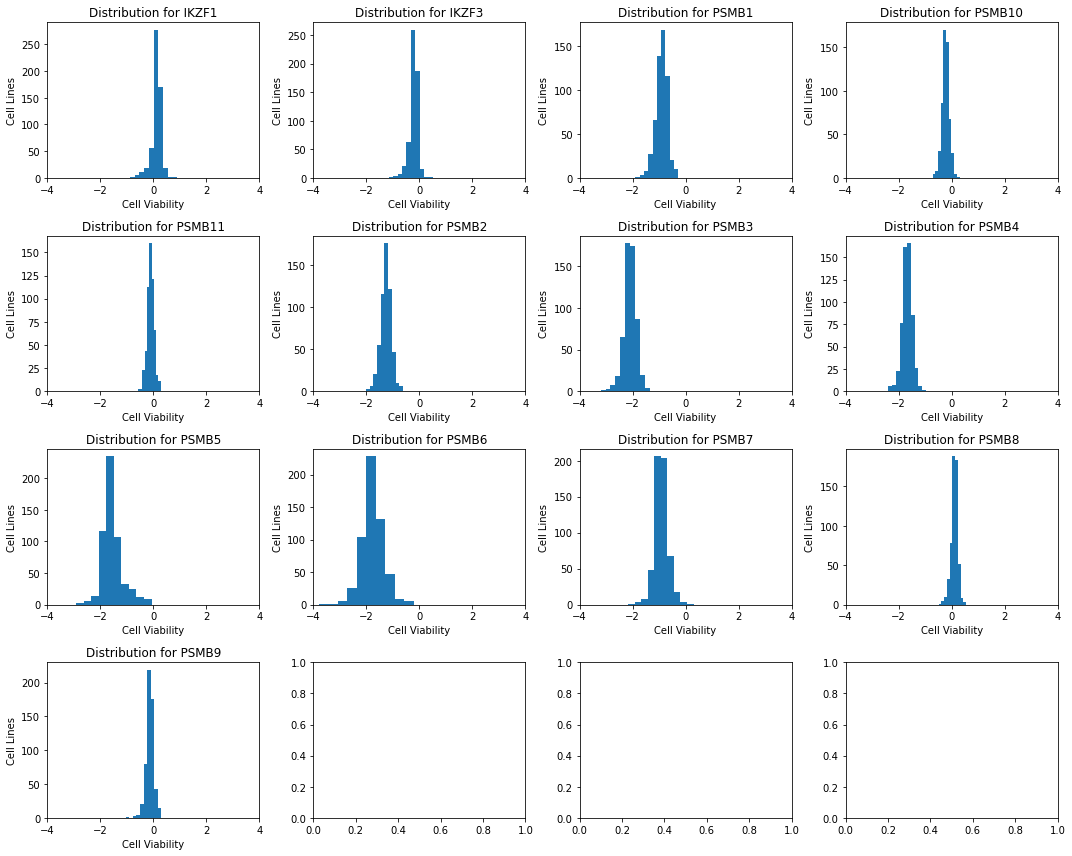

In [18]:
fig, ax = plt.subplots(4, 4, figsize = (15,12))

ax_new = Y_train.hist(bins=10, ax=ax.ravel()[:13])
for i in range(13):
    ax_new[i].set_xlabel("Cell Viability")
    ax_new[i].set_ylabel("Cell Lines") 
    ax_new[i].set_title(f"Distribution for {Y_train.columns[i].split(' ')[0]}")
    ax_new[i].set_xlim(-1*4,4)
    ax_new[i].grid(False)

plt.tight_layout()
plt.savefig('histograms.png')

## Define classifier architecture

In [19]:
def generate_classifier(N_in):
    inputs = K.layers.Input(shape = (N_in,))
    x = K.layers.Dense(64, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(inputs)
    x = K.layers.Dense(32, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(x)   
    y1 = K.layers.Dense(2, activation='softmax', kernel_regularizer=K.regularizers.l2(l=0.01), name='y1')(x)
    y2 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y2')(x)
    y3 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y3')(x)
    y4 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y4')(x)
    y5 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y5')(x)
    y6 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y6')(x)
    y7 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y7')(x)
    y8 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y8')(x)
    y9 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y9')(x)
    y10 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y10')(x)
    y11 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y11')(x)
    y12 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y12')(x)
    y13 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y13')(x)
    
    combined = [y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13]
    tensors = [tf.expand_dims(i, axis=1) for i in combined]
    output = K.layers.concatenate(tensors, axis=1)
    
    model = K.models.Model(inputs = inputs, outputs = output)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [20]:
def plot_loss(perf_dict):
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    loss = perf_dict['loss']
    val_loss = perf_dict['val_loss']
    ax1.plot(loss)
    ax2.plot(val_loss)
    ax1.set_xlabel('epochs')
    ax2.set_xlabel('epochs')

    ax1.set_ylabel('loss')
    ax2.set_ylabel('val_loss')
    plt.show()

## Train Classifier Model

In [21]:
classifier = generate_classifier(X_train.shape[1])
classifier.summary()

print("Input", classifier.input_shape)
print("Output", classifier.output_shape)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           8256        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
__________________________________________________________________________________________________
y1 (Dense)                      (None, 2)            66          dense_1[0][0]                    
______________________________________________________________________________________________

In [22]:
classifier_history = classifier.fit(X_train,bY_train_oneHot,epochs=100, validation_data=(X_val, bY_val_oneHot),verbose=0)

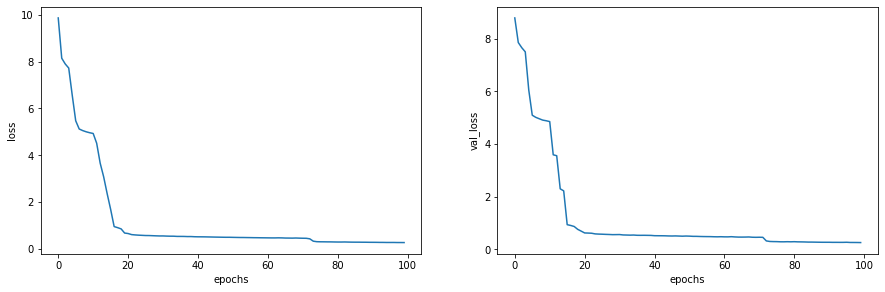

In [23]:
plot_loss(classifier_history.history)

In [24]:
y_train_classifierPred = np.array(classifier.predict(X_train))[:,:,1]
y_test_classifierPred = np.array(classifier.predict(X_test))[:,:,1]

bY_test_true = bY_test_oneHot[:,:,1]
bY_train_true = bY_train_oneHot[:,:,1]

print(y_train_classifierPred.shape, y_test_classifierPred.shape)
print(bY_train_true.shape, bY_test_true.shape)

(559, 13) (165, 13)
(559, 13) (165, 13)


In [25]:
n_classes = 13
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bY_test_true[:, i], y_test_classifierPred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(bY_test_true.ravel(), y_test_classifierPred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/Users/eshikasaxena/miniconda3/envs/cs109b/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/Users/eshikasaxena/miniconda3/envs/cs109b/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/Users/eshikasaxena/miniconda3/envs/cs109b/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/Users/eshikasaxena/miniconda3/envs/cs109b/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true

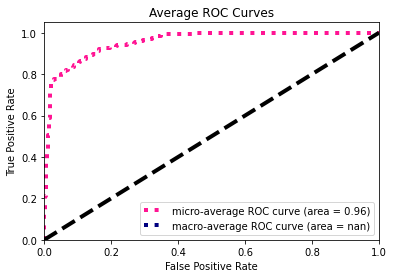

In [26]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curves')
plt.legend(loc="lower right")
plt.show()

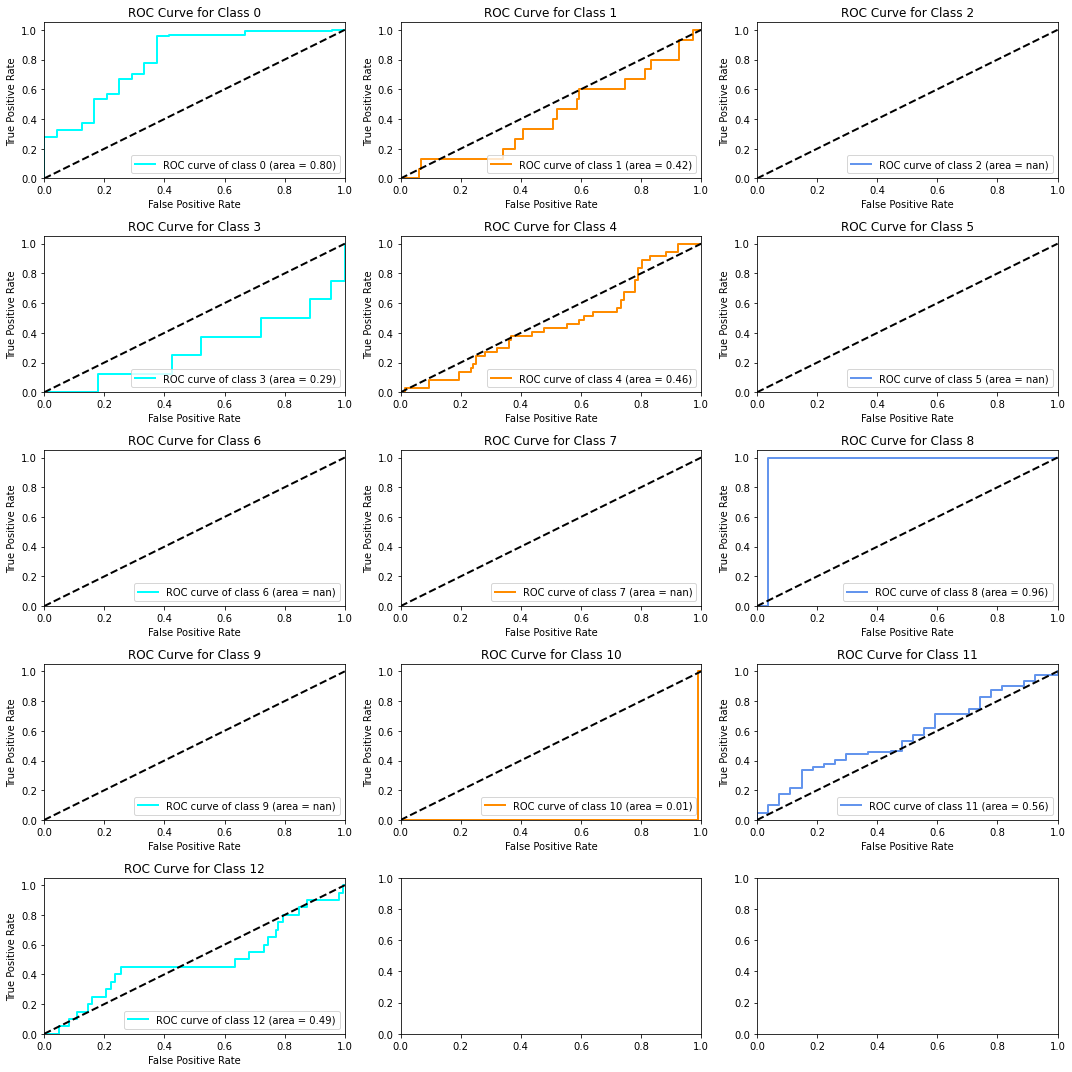

In [27]:
fig, axes = plt.subplots(5, 3, figsize=(15,15))
lw = 2

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, ax, color in zip(range(13), axes.ravel(), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for Class {i}')
    ax.legend(loc="lower right")

plt.tight_layout()

## Fine-tuning on patient data
Freeze network except the last layer, then train on patient data

In [28]:
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           8256        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
__________________________________________________________________________________________________
y1 (Dense)                      (None, 2)            66          dense_1[0][0]                    
______________________________________________________________________________________________

In [29]:
classifier.layers[0].trainable = False
classifier.layers[1].trainable = False
classifier.layers[2].trainable = False

transfer = classifier.layers[2].output

final_output = K.layers.Dense(2, activation='softmax', kernel_regularizer=K.regularizers.l2(l=0.01), name='final')(transfer)

transfer_model = K.models.Model(inputs=classifier.input, outputs=final_output)

transfer_model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

print(transfer_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
final (Dense)                (None, 2)                 66        
Total params: 10,402
Trainable params: 66
Non-trainable params: 10,336
_________________________________________________________________
None


In [30]:
history_pt = transfer_model.fit(X_train_pt, bY_train_pfs_oneHot, epochs=100, validation_data=(X_val_pt, bY_val_pfs_oneHot))

Epoch 1/100
10/10 [==============================] - 1s 24ms/step - loss: 1.0329 - accuracy: 0.4894 - val_loss: 0.8071 - val_accuracy: 0.5773
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.9855 - accuracy: 0.5187 - val_loss: 0.7997 - val_accuracy: 0.5876
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 0.9939 - accuracy: 0.5549 - val_loss: 0.7934 - val_accuracy: 0.5876
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 0.9951 - accuracy: 0.4990 - val_loss: 0.7878 - val_accuracy: 0.5979
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 1.0054 - accuracy: 0.5265 - val_loss: 0.7824 - val_accuracy: 0.6186
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 0.9180 - accuracy: 0.5643 - val_loss: 0.7775 - val_accuracy: 0.6186
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 0.9398 - accuracy: 0.5710 - val_loss: 0.7730 - val_accuracy: 0.6289
Epoch 8/100


Epoch 59/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6998 - accuracy: 0.6764 - val_loss: 0.7046 - val_accuracy: 0.6289
Epoch 60/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6966 - accuracy: 0.6851 - val_loss: 0.7044 - val_accuracy: 0.6186
Epoch 61/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6958 - accuracy: 0.6775 - val_loss: 0.7039 - val_accuracy: 0.6186
Epoch 62/100
10/10 [==============================] - 0s 6ms/step - loss: 0.7178 - accuracy: 0.6387 - val_loss: 0.7040 - val_accuracy: 0.6186
Epoch 63/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.6853 - val_loss: 0.7040 - val_accuracy: 0.6186
Epoch 64/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.6763 - val_loss: 0.7038 - val_accuracy: 0.6186
Epoch 65/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6848 - accuracy: 0.6788 - val_loss: 0.7040 - val_accuracy: 0.6186
Epoch 

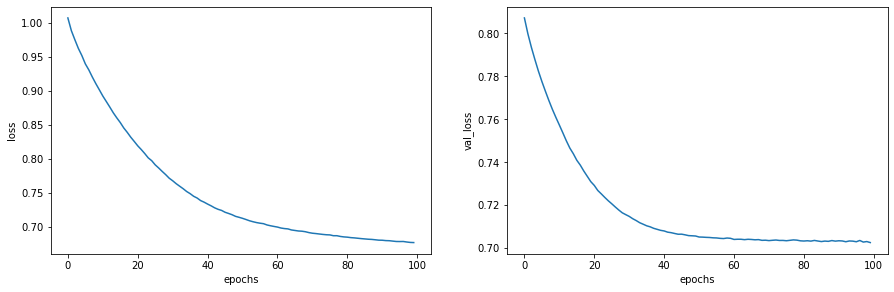

In [31]:
plot_loss(history_pt.history)

In [32]:
y_train_transferPred_probs = np.array(transfer_model.predict(X_train_pt))[:,1]
y_test_transferPred_probs = np.array(transfer_model.predict(X_test_pt))[:,1]

y_train_transferPred = np.where(y_train_transferPred_probs > 0.5, 1, 0)
y_test_transferPred = np.where(y_test_transferPred_probs > 0.5, 1, 0)

bY_train_true_pfs = bY_train_pfs_oneHot[:,1]
bY_test_true_pfs = bY_test_pfs_oneHot[:,1]

print(y_train_transferPred.shape, y_test_transferPred.shape)
print(bY_train_true_pfs.shape, bY_test_true_pfs.shape)

(313,) (142,)
(313,) (142,)


## Baseline model

In [33]:
inputs = K.layers.Input(shape = (128,))
x = K.layers.Dense(64, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(inputs)
x = K.layers.Dense(32, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(x)

output = K.layers.Dense(2, activation='softmax', kernel_regularizer=K.regularizers.l2(l=0.01), name='final')(x)

baseline_model = K.models.Model(inputs=inputs, outputs=output)

baseline_model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

print(baseline_model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
final (Dense)                (None, 2)                 66        
Total params: 10,402
Trainable params: 10,402
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
history_baseline = baseline_model.fit(X_train_pt, bY_train_pfs_oneHot, epochs=100, validation_data=(X_val_pt, bY_val_pfs_oneHot))

Epoch 1/100
10/10 [==============================] - 1s 23ms/step - loss: 5.3533 - accuracy: 0.5081 - val_loss: 3.4432 - val_accuracy: 0.4227
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 3.1898 - accuracy: 0.5790 - val_loss: 2.8798 - val_accuracy: 0.5258
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 2.2693 - accuracy: 0.6788 - val_loss: 2.5700 - val_accuracy: 0.5258
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 1.8183 - accuracy: 0.7283 - val_loss: 2.4616 - val_accuracy: 0.5670
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 1.6647 - accuracy: 0.7923 - val_loss: 2.4794 - val_accuracy: 0.4948
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 1.4457 - accuracy: 0.8927 - val_loss: 2.4379 - val_accuracy: 0.5052
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 1.3368 - accuracy: 0.9250 - val_loss: 2.3727 - val_accuracy: 0.5155
Epoch 8/100


Epoch 59/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6296 - accuracy: 1.0000 - val_loss: 1.9812 - val_accuracy: 0.5773
Epoch 60/100
10/10 [==============================] - 0s 17ms/step - loss: 0.6213 - accuracy: 1.0000 - val_loss: 1.9883 - val_accuracy: 0.5773
Epoch 61/100
10/10 [==============================] - 0s 15ms/step - loss: 0.6148 - accuracy: 1.0000 - val_loss: 1.9708 - val_accuracy: 0.5876
Epoch 62/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6083 - accuracy: 1.0000 - val_loss: 1.9718 - val_accuracy: 0.5773
Epoch 63/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6013 - accuracy: 1.0000 - val_loss: 1.9480 - val_accuracy: 0.5773
Epoch 64/100
10/10 [==============================] - 0s 16ms/step - loss: 0.5949 - accuracy: 1.0000 - val_loss: 1.9436 - val_accuracy: 0.5876
Epoch 65/100
10/10 [==============================] - 0s 9ms/step - loss: 0.5878 - accuracy: 1.0000 - val_loss: 1.9392 - val_accuracy: 0.5773
E

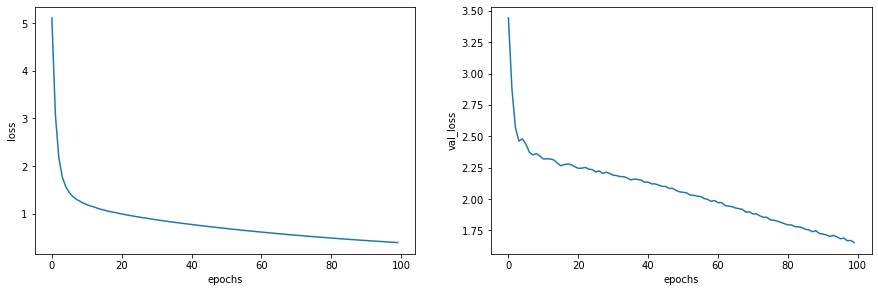

In [35]:
plot_loss(history_baseline.history)

In [36]:
y_train_baselinePred_probs = np.array(baseline_model.predict(X_train_pt))[:,1]
y_test_baselinePred_probs = np.array(baseline_model.predict(X_test_pt))[:,1]

y_train_baselinePred = np.where(y_train_baselinePred_probs > 0.5, 1, 0)
y_test_baselinePred = np.where(y_test_baselinePred_probs > 0.5, 1, 0)

bY_train_true_pfs = bY_train_pfs_oneHot[:,1]
bY_test_true_pfs = bY_test_pfs_oneHot[:,1]

print(y_train_transferPred.shape, y_test_transferPred.shape)
print(bY_train_true_pfs.shape, bY_test_true_pfs.shape)

(313,) (142,)
(313,) (142,)


## Calculate and display metrics

In [37]:
def get_stats(true_pfs,pred_pfs):
    metrics = [accuracy_score, precision_score, recall_score, f1_score]
    return([np.round(metric(true_pfs, pred_pfs),2) for metric in metrics])

In [38]:
val_stats_baseline = get_stats(bY_test_true_pfs, y_test_baselinePred)
auc_baseline = np.round(roc_auc_score(bY_test_true_pfs, y_test_baselinePred_probs),2)

val_stats_transfer = get_stats(bY_test_true_pfs, y_test_transferPred)
auc_transfer = np.round(roc_auc_score(bY_test_true_pfs, y_test_transferPred_probs),2)

results_df = (pd.DataFrame({'Experiment': ['Baseline','CRISPR'],
                        'AUC': [auc_baseline,auc_transfer],
                      'Accuracy': [val_stats_baseline[0],val_stats_transfer[0]],
                            'F1': [val_stats_baseline[3],val_stats_transfer[3]],
                      'Precision': [val_stats_baseline[1],val_stats_transfer[1]],
                      'Recall': [val_stats_baseline[2],val_stats_transfer[2]]},
                      index=[0,1]))

display(results_df)

,Experiment,AUC,Accuracy,F1,Precision,Recall
0,Baseline,0.60,0.6,0.66,0.64,0.69
1,CRISPR,0.56,0.6,0.73,0.59,0.98
